### 開発環境・主要なライブラリ

> Python3.7.8
>
> OpenCV (画像処理)
>
> Scikit-learn (機械学習)
>
> pickle (機械学習のモデルを保存読込)
>
> pyautogui (Unity 環境のロボットを操作)
>
> matplotlib (画像認識の結果をグラフ表示)


In [15]:
# import
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from tqdm.notebook import trange
from numba import jit
from pprint import pprint
from joblib import Parallel, delayed
from sklearn import svm, neural_network
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler

# カメラを起動する
camera = cv2.VideoCapture(0)
CAMERA_SIZE = (50, 85) # 取得した写真はこのサイズに縮小する

# ライントレースの行動クラス番号
LEFT_ACTCODE = 0
RIGHT_ACTCODE = 1
LEFT90_ACTCODE = 2
RIGHT90_ACTCODE = 3
STRAIGHT_ACTCODE = 4

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


## 色識別の機械学習モデルをつくる

### 機械学習モデル

1. 非線形サポートベクターマシン(sklearn.svm.svc)
2. パラメータの調整と最適化 = なし
3. 説明変数 = 特定の色から取得した RGB 値
4. 目的変数 = 色

### 学習工程

1. 白黒緑のそれぞれの色を示す写真をカメラから取得する。(画面全体にその色が表示されていることが必須)
2. 取得した画像に含まれるピクセルすべてをサンプルとして加工する。(RGB 値を格納した 1 次元配列に変換する)
3. ピクセルの RGB 値を学習させる。

### サポートベクターマシンとは

教師あり学習の機械学習モデルの中でも分類に特化したモデル。学習時にサンプル分類の基準となる線(サポートベクターと呼ぶ)を生成し、未知のサンプルを分類するときにはその線との位置関係によって分類を行う。

### 非線形サポートベクターマシン(SVC)を利用した理由

SVM の利点はパラメータの調整と最適化が不要なことである。そして有名な機械学習モデルであるためドキュメントや解説記事が豊富に見つけられる。そのため SVM は便利なモデルであると言える。

また、SVM は分類するクラス(目的変数)が多すぎると分析精度が下がり、スケーリング(数値の規模を統一すること)が必要という難点がある。しかしながら今回のような分類問題は、分類するクラスは白･黒･緑の 3 つであり、RGB 値は 0~255 の範囲で表されるため、問題とはならないと考えた。


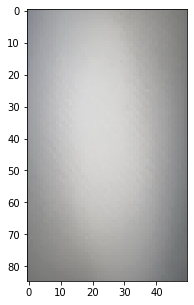

In [18]:
# 白色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame,dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

WhiteRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


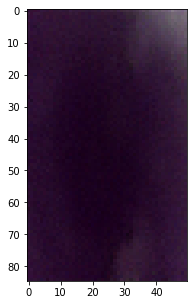

In [40]:
# 黒色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

BlackRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


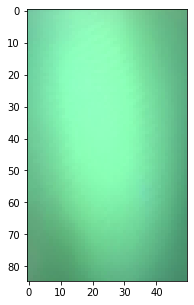

In [42]:
# 緑色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

GreenRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


In [43]:
# 色識別の分類モデルを作る(SVM)

# それぞれの色に0,1,2の分類をつける
WhiteRGB_sample = [[point[0], point[1], point[2], 0]
                   for point in WhiteRGB_sample]
BlackRGB_sample = [[point[0], point[1], point[2], 1]
                   for point in BlackRGB_sample]
GreenRGB_sample = [[point[0], point[1], point[2], 2]
                   for point in GreenRGB_sample]

allOf_samples = np.concatenate(
    [WhiteRGB_sample, BlackRGB_sample, GreenRGB_sample])

allOf_samples = LoadInstances(path="allOf_samples.pickles")

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = svm.SVC().fit(X_train, y_train) # 学習

SaveInstances(instance=model, path="ColorModel.pickles")


C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


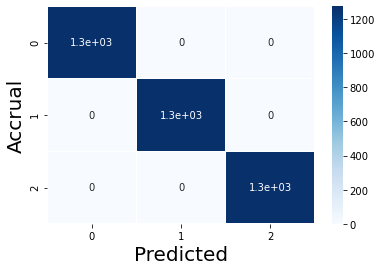

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1275
           1       1.00      1.00      1.00      1275
           2       1.00      1.00      1.00      1275

    accuracy                           1.00      3825
   macro avg       1.00      1.00      1.00      3825
weighted avg       1.00      1.00      1.00      3825



In [44]:
# 色識別の分類モデルをテストする

model = LoadInstances("ColorModel.pickle")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


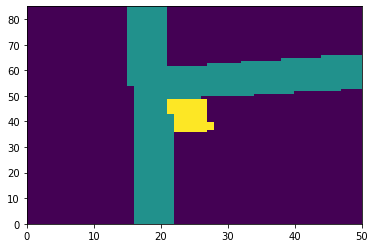

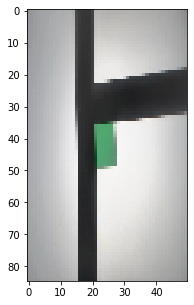

Timer unit: 1e-07 s

Total time: 0.582603 s
File: C:\Users\Haya\AppData\Local\Temp/ipykernel_21172/470189583.py
Function: func_Classification at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def func_Classification():
     3         1      72868.0  72868.0      1.3      ret, raw_frame = camera.read()
     4         1        616.0    616.0      0.0      frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
     5         1         33.0     33.0      0.0      height, width = frame.shape[:2]
     6                                           
     7         1     228505.0 228505.0      3.9      result = [model.predict(row) for row in reversed(frame)]
     8                                           
     9         1       8420.0   8420.0      0.1      plt.clf()
    10         1     409590.0 409590.0      7.0      plt.pcolormesh(result)
    11         1    2434143.0 2434143.0     41.8      plt.pause(0.01)
    12        

In [48]:
# 色識別の分類モデルを使って、タイルを色分類してみる
def func_Classification():
    ret, raw_frame = camera.read()
    frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
    height, width = frame.shape[:2]

    result = [model.predict(row) for row in reversed(frame)]

    plt.clf()
    plt.pcolormesh(result)
    plt.pause(0.01)

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.01)


lp = LineProfiler()
lp.add_function(func_Classification)
lp.runcall(func_Classification)
lp.print_stats()


## タイル分類の機械学習モデルをつくる

### 機械学習モデル

1. ニューラルネットワーク(多層パーセプトロン分類)
2. パラメータの調整と最適化 = なし
3. 説明変数 = カメラから取得したタイルの写真を色識別モデルで分類したもの
4. 目的変数 = ロボットが進行すべき方向(左～前～右)

### 学習工程

1. 動画編集ソフトでタイルを模した動画を作成する(タイルの画像を乱数で移動回転させることであらゆる外乱を再現できる)
2. 作成した動画からフレームごとに写真を抜き出し、それを色識別モデルで分類させる
3. 色識別済みのタイル写真を学習させる。

### ニューラルネットワークとは

人間の脳神経細胞(ニューロン)を模した機械学習モデル。ニューロンは与えられた情報をもとに、他のニューロンに情報を出力する。

また、ニューラルネットワーク全体を見ると入力層･処理層･出力層に分類することができる。入力層には説明変数を与え、処理層ではニューロンが判断を行い、出力層から目的変数が返される。

### ニューラルネットワークを利用した理由

このモデルはパターン認識に特に適しており、画像認識や音声認識、時系列予測などにも利用されている。これらはライントレースのタイル識別にもよく似ている認識問題だ。

また、多層パーセプトロンでは大量のニューロンが認識処理に関わるため、より複雑な処理が行なえる。したがってライントレースのタイル認識にも十分な性能を発揮できると考える。


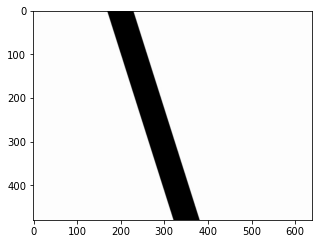

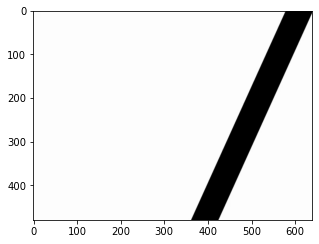

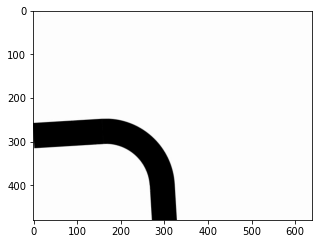

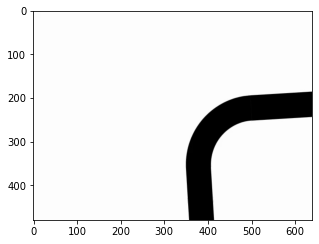

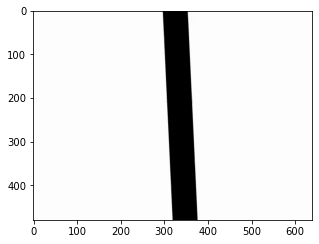

In [49]:
# タイルのサンプルを集める
# タイルのサンプルを集める (左に曲がる)
Left_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/left_vid.mp4"

vid = cv2.VideoCapture(Left_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (右に曲がる)
Right_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/right_vid.mp4"

vid = cv2.VideoCapture(Right_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (90度に左に曲がる)
Left90_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/left90_vid.mp4"

vid = cv2.VideoCapture(Left90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (90度に右に曲がる)
Right90_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/right90_vid.mp4"

vid = cv2.VideoCapture(Right90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (真っ直ぐ進む)
Straight_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/stright_vid.mp4"

vid = cv2.VideoCapture(Straight_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


In [50]:
# ライントレースの判断モデルを作る(NeuralNetwork)
pathList = [
    # それぞれの行動パターンに番号を振り与える
    [Left_videoPath, LEFT_ACTCODE],
    [Right_videoPath, RIGHT_ACTCODE],
    [Left90_videoPath, LEFT90_ACTCODE],
    [Right90_videoPath, RIGHT90_ACTCODE],
    [Straight_videoPath, STRAIGHT_ACTCODE],
]

model = LoadInstances("ColorModel.pickle")
allOf_samples = np.empty((1, CAMERA_SIZE[0] * CAMERA_SIZE[1] + 1))

for pl in pathList:
    path = pl[0]
    act = pl[1]
    vid = cv2.VideoCapture(path)
    frame_count = math.floor(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    for f in tqdm(range(frame_count)):
        count += 1
        if count % 10 == 0:
            ret, raw_frame = vid.read()
            frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
            res = np.array([model.predict(row) for row in reversed(frame)])
            res = np.append(res, act)
            allOf_samples = np.append(allOf_samples, [res], axis=0)

allOf_samples = allOf_samples[1:]
pprint(allOf_samples)

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = neural_network.MLPClassifier().fit(X_train, y_train)


100%|██████████| 6160/6160 [00:24<00:00, 247.47it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.]])


C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [51]:
# ライントレースの判断モデルを作る(NeuralNetwork without SVM-ColorClassify)
pathList = [
    # それぞれの行動パターンに番号を振り与える
    [Left_videoPath, LEFT_ACTCODE],
    [Right_videoPath, RIGHT_ACTCODE],
    [Left90_videoPath, LEFT90_ACTCODE],
    [Right90_videoPath, RIGHT90_ACTCODE],
    [Straight_videoPath, STRAIGHT_ACTCODE],
]

allOf_samples = np.empty((1, (CAMERA_SIZE[0] * CAMERA_SIZE[1]) * 3 + 1))

for pl in pathList:
    path = pl[0]
    act = pl[1]
    vid = cv2.VideoCapture(path)
    frame_count = math.floor(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    for f in tqdm(range(frame_count)):
        count += 1
        if count % 10 == 0:
            ret, raw_frame = vid.read()
            frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
            res = np.ravel(frame)
            res = np.append([res], act)
            allOf_samples = np.append(allOf_samples, [res], axis=0)

allOf_samples = allOf_samples[1:]

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = neural_network.MLPClassifier().fit(X_train, y_train)


100%|██████████| 6160/6160 [00:39<00:00, 157.38it/s]
C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


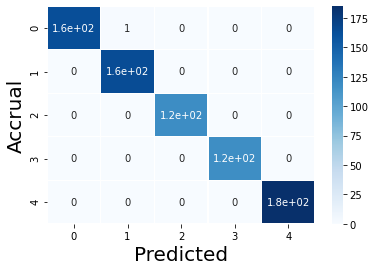

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       165
         1.0       0.99      1.00      1.00       165
         2.0       1.00      1.00      1.00       119
         3.0       1.00      1.00      1.00       118
         4.0       1.00      1.00      1.00       185

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



In [52]:
# ライントレースの判断モデルをテストする

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


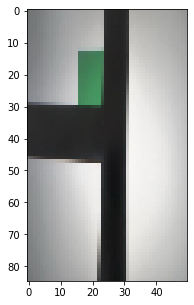

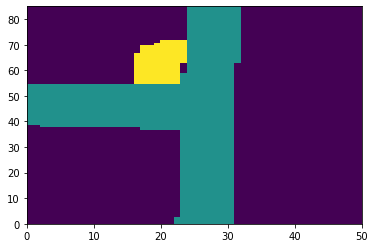

STRAIGHT


In [57]:
# ライントレースの判断モデルを使ってタイルを見させてみる

model_color = LoadInstances("ColorModel.pickle")
model_decision = LoadInstances("NeuralDecision.pickle")

# カメラで撮影する
camera = cv2.VideoCapture(0)
ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

# カメラからの写真を表示する
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)
plt.pause(0.1)

# 写真を色識別する
result = [model_color.predict(row) for row in reversed(frame)]
plt.clf()
plt.pcolormesh(result)
plt.pause(0.01)

res = model_decision.predict([np.ravel(result)])[0]

acttype = [
    [LEFT_ACTCODE, "LEFT"],
    [RIGHT_ACTCODE, "RIGHT"],
    [LEFT90_ACTCODE, "LEFT90"],
    [RIGHT90_ACTCODE, "RIGHT90"],
    [STRAIGHT_ACTCODE, "STRAIGHT"],
]

for at in acttype:
    if res == at[0]:
        print(at[1])
